In [2]:
from pandas import read_csv
from pathlib import Path

df = read_csv(Path(".").joinpath("data/results/tables/harmonic_load_signal_trends.csv"))

/tmp/ipykernel_593605/3374073235.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["Love_numbers_ID"] == 1][df["leakage_correction_iterations"] == leakage_correction_iterations]
/tmp/ipykernel_593605/3374073235.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["Love_numbers_ID"] == 1][df["leakage_correction_iterations"] == leakage_correction_iterations]
/tmp/ipykernel_593605/3374073235.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["Love_numbers_ID"] == 1][df["leakage_correction_iterations"] == leakage_correction_iterations]


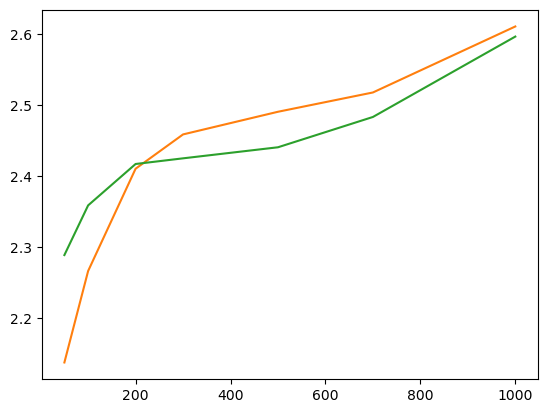

In [3]:
from matplotlib.pyplot import plot

d = [50, 100, 200, 300, 500, 700, 1000]
for leakage_correction_iterations in range(3):
    result_list = (
        df[df["Love_numbers_ID"] == 1][df["leakage_correction_iterations"] == leakage_correction_iterations]
        .sort_values(by="buffer_distance")["ocean_mean_step_3"]
        .values
    )
    plot(d[: len(result_list)], result_list)